# Order Imbalance Strategy in Chinese Future Markets

# Introduction
This project is to replicate the paper from D.Shen(2015), who analysed the factor 'Order imbalance' to have a significant impact on the change in CSI300 Futures tick data backed in 2014. Here are his findings:

1. Developed a trading strategy by fitting the order imbalance factor model to forecast 10 seconds mid price change.
2. Model shows high profitability when trading signal is greater than 0.2 ticks.
3. Profits made by the strategy are strongly correlated with the total trading volume in the market

Additional findings:
1. Improved trading signal by extending model to 2 more factors : Order imbalance ratio and mid price basis mean reversion, and divided variables by bid-ask spread. 
2. Large spread indicates low price change
3. Trading parameters optimization : Forecast window for average change and trading threshold were closer to 5 and 0.15 respectively

Results from D.Shen(2015):
1. Average Correlation coefficeint of OI and instantaneous mid-price change : 0.3935
2. Fitting a linear regression model gives average daily R-squared : 0.155
3. Correlation between 10s interval between price change and VOI R-squared: 0.6537
4. Variable samples proved to be stationary by ADF/KPSS test

# Step 1 : Identifying Objectives
The first step of this project is to define what we are looking for. In my own understanding, the whole research can guide us to potential trading strategy and we are about to find out whether the key factor fits well with the data. D.Shen(2015) has proven a significant amount of profit backing up by the linear model. That means the signal(alpha) has a robust performance in the CSI300 Future tick data. The next step is to perform data cleaning. It is crucially important because uncleaned data may lead to irregular results.

# Step 2 : Checking & tidying data
Facts about the SHFE tick data set:
1. Tick data from 00:00:00.000 to 23:59:59.500 GMT+8
2. Interval per each entry : 5ms difference(Snapshot data)
3. 16 Future contracts with 12 expiries & Multiple Option contracts(Not included in this research). e.g. RB1912 to RB2012
4. LEVEL 2 quote.
5. Volume and Turnover resets at 21:00:00.000 for all contracts, which means, volume and turnover counts from previous day's 21:00:00.000 for contracts that trades during night session.

There are some data cleaning procedures before we continue our analysis. 
1. The time is not in datetime format so we need to convert it to that. 
2. Filtering out option contracts because we are not comparing them in this project
3. Obtain only for Active contracts for the highest volume
4. NaN values need to be removed

In [29]:
import numpy as np
import os
import pandas as pd
import statsmodels.api as sm
import datetime as dt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#read file
df = pd.read_csv('ShfeMulti_20191031.csv', index_col=None, header=None)
df.columns = ['Timestamp','Contract', 'time','last_price','volume','turnover','open_interest', #rename column
              'BP1','BV1','AP1','AV1',
              'BP2','BV2','AP2','AV2',
              'BP3','BV3','AP3','AV3',
              'BP4','BV4','AP4','AV4',
              'BP5','BV5','AP5','AV5']

pd.set_option('display.float_format', '{:.2f}'.format) #Set display decimals


#Convert datetime object as Index
df = df.sort_values(['time'], ascending=True) #Sort time
df.time  = pd.to_datetime(df.time) #Convert time to datetime object
df.time  = pd.to_datetime(df.time).dt.strftime('%H:%M:%S.%f')##Remove Y/M/D , I only want H/M/S 

#obtain time from 09:00 - 15:00, Not including night session
df = df[(df.time >= '08:59:00.000') & (df.time <='15:00:00.500')]
df = df.set_index('time')#Set time as index

#Obtaining Active contract names 
#df = df[['Contract','volume','turnover', 'BP1','BV1','AP1','AV1']]
#filter out option contracts, more than 6 characters are options contracts
df = df[df['Contract'].str.len() <= 6]
#Filter in Active Contract, all contracts doesn't work...
df['Contract1'] = df.Contract.str.slice(start=0,stop =2)
df['Contract2'] = df.Contract.str.slice(start=2)
temp = df.groupby('Contract').max().reset_index()
temp= temp[['volume','Contract1','Contract']]
temp = temp[temp.volume == temp.groupby('Contract1')['volume'].transform('max')]
main = temp.Contract.to_numpy()
df = df[df['Contract'].isin(main)] 
df = df.sort_values(['time','Contract'], ascending=True)

#Remove NaNs 
df.dropna(inplace = True)

df.sort_values(['Contract1'], ascending=True)

df.head()

rb = df[df.Contract1=='rb']
df

,Timestamp,Contract,last_price,volume,turnover,open_interest,BP1,BV1,AP1,AV1,BP2,BV2,AP2,AV2,BP3,BV3,AP3,AV3,BP4,BV4,AP4,AV4,BP5,BV5,AP5,AV5,Contract1,Contract2
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,
08:59:00.500000,3283647182.29,wr2001,3660.00,0.00,0.00,30.00,3636.00,1.00,3690.00,1.00,3620.00,1.00,3720.00,1.00,3606.00,1.00,3760.00,1.00,3566.00,1.00,3786.00,1.00,3506.00,1.00,3880.00,2.00,wr,2001
09:00:00.500000,3283707180.75,ag1912,4352.00,663578.00,43350185370.00,811918.00,4351.00,110.00,4352.00,24.00,4350.00,1032.00,4353.00,5.00,4349.00,43.00,4354.00,62.00,4348.00,77.00,4355.00,18.00,4347.00,32.00,4356.00,451.00,ag,1912
09:00:00.500000,3283707180.77,al1912,13815.00,22590.00,1561775000.00,230674.00,13810.00,52.00,13815.00,13.00,13805.00,338.00,13820.00,68.00,13800.00,81.00,13825.00,29.00,13795.00,108.00,13830.00,59.00,13790.00,67.00,13835.00,186.00,al,1912
09:00:00.500000,3283707180.78,au1912,341.20,181304.00,61837871700.00,347730.00,341.05,7.00,341.20,15.00,341.00,6.00,341.25,53.00,340.95,4.00,341.30,5.00,340.90,15.00,341.35,10.00,340.85,102.00,341.40,8.00,au,1912
09:00:00.500000,3283707180.80,bu1912,2948.00,335662.00,9884005640.00,430862.00,2944.00,51.00,2948.00,2.00,2942.00,201.00,2950.00,47.00,2940.00,237.00,2952.00,158.00,2938.00,214.00,2954.00,149.00,2936.00,251.00,2956.00,254.00,bu,1912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15:00:00.000000,3305307025.49,rb2001,3367.00,2997816.00,101147520960.00,3195424.00,3366.00,112.00,3367.00,10.00,3365.00,1474.00,3368.00,1016.00,3364.00,678.00,3369.00,973.00,3363.00,539.00,3370.00,1334.00,3362.00,1170.00,3371.00,586.00,rb,2001
15:00:00.000000,3305307025.49,ru2001,12015.00,455718.00,54724009700.00,342110.00,12015.00,12.00,12020.00,98.00,12010.00,32.00,12025.00,87.00,12005.00,30.00,12030.00,211.00,12000.00,157.00,12035.00,133.00,11995.00,99.00,12040.00,147.00,ru,2001
15:00:00.000000,3305307025.50,sn2001,138340.00,20180.00,2789623880.00,39230.00,138330.00,4.00,138340.00,2.00,138320.00,1.00,138350.00,1.00,138300.00,4.00,138390.00,1.00,138290.00,3.00,138400.00,8.00,138280.00,3.00,138410.00,1.00,sn,2001


In [32]:
#Volume accumulation for every contracts. RB, AG, FU has the highest volume.
volume_count = df[['volume','Contract1']].groupby('Contract1').apply(sum)
volume_count['volume']

Contract1
ag   25172749192.00
al     434768328.00
au    4354080668.00
bu   10221704766.00
cu    1055394638.00
fu   17250023230.00
hc    6227083270.00
ni   12346535682.00
pb     282485688.00
rb   51368828862.00
ru    7806652312.00
sn     108362026.00
sp    1298778370.00
ss      12683204.00
wr         22538.00
zn    2990507302.00
Name: volume, dtype: float64

In [10]:
def midprice(df):
    midprice = (df.BP1 +df.AP1)/2
    return midprice

#Bid Ask Spread
def BAS(df):
    return (df.AP1 - df.BP1)

#Order Imbalance Ratio
def OIR(df):
    return ((df.BV1 - df.AV1)/(df.BV1 + df.AV1))

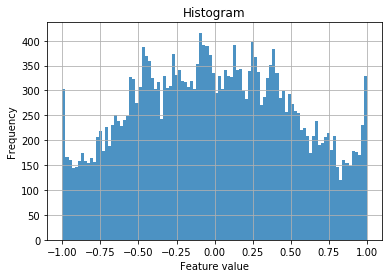

In [5]:
import matplotlib.pyplot as plt
from IPython.display import display
pd.Series(OIR(rb)).plot.hist(alpha=0.8, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("Feature value")
plt.title("Histogram")
plt.show()

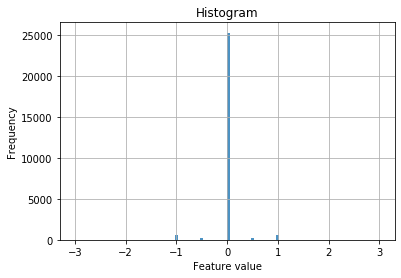

In [13]:
#Histogram of MidPrice change 
pd.Series(midprice(rb).diff()).plot.hist(alpha=0.8, bins=100, grid=True, legend=None)  # Pandas helper function to plot a hist. Uses matplotlib under the hood.
plt.xlabel("Feature value")
plt.title("Histogram")
plt.show()


In [6]:
OIR(rb)

time
09:00:00.500000   -0.97
09:00:01.000000   -0.95
09:00:01.500000    0.28
09:00:02.000000    0.23
09:00:02.500000   -0.69
                   ... 
14:59:58.000000    0.26
14:59:58.500000    0.07
14:59:59.000000    0.41
14:59:59.500000    0.60
15:00:00.000000    0.84
Length: 26874, dtype: float64

In [14]:
#Obtaining ticksize
def ticksize(df):
    x=df['BP1'].diff()
    x = x.replace(0, np.nan)
    x.dropna(inplace=True)
    return abs(x.value_counts().idxmax())

temp = df.groupby('Contract').apply(midprice).diff()/df.groupby('Contract').apply(ticksize)
df.groupby('Contract').apply(ticksize)

Contract
ag1912    1.00
al1912    5.00
au1912    0.05
bu1912    2.00
cu1912   10.00
fu2001    1.00
hc2001    1.00
ni1912   10.00
pb1912    5.00
rb2001    1.00
ru2001    5.00
sn2001   10.00
sp2001    2.00
ss2002    5.00
wr2001    1.00
zn1912    5.00
dtype: float64

Now have our change in midprice normalized against ticksize. We can conduct our analysis. The first one is **Correlation**. 

In [18]:
#Correlation between Mid price change and Lagged Order imbalance ratio
pd.set_option('display.float_format', '{:.4f}'.format)
def cor(df):
    cor = np.corrcoef(midprice(df).diff()[1:]/ticksize(df),OIR(df)[:-1])[1,0]
    return cor

correlation_table = pd.DataFrame(df.groupby('Contract').apply(cor))
print(correlation_table)

              0
Contract       
ag1912   0.2641
al1912   0.2214
au1912   0.2937
bu1912   0.2244
cu1912   0.2635
fu2001   0.2345
hc2001   0.3040
ni1912   0.3271
pb1912   0.3217
rb2001   0.2998
ru2001   0.2897
sn2001   0.1461
sp2001   0.1995
ss2002   0.2518
wr2001   0.0305
zn1912   0.3132


In [19]:
#Autocorrelation coefficient for dM with lag from 0 to 5
def dM_autocor(df):
    temp = midprice(df).diff()/ticksize(df)
    autocor = pd.Series([round(temp.autocorr(lag = i),2) for i in range(0,6)])
    return autocor

autocorrr = df.groupby('Contract').apply(dM_autocor)
autocorrr

,0,1,2,3,4,5
Contract,,,,,,
ag1912,1.0000,-0.1100,-0.0500,-0.0300,-0.0100,-0.0200
al1912,1.0000,-0.0700,-0.1000,-0.0800,-0.0100,-0.0300
au1912,1.0000,-0.1900,-0.0600,-0.0400,-0.0300,-0.0000
bu1912,1.0000,-0.0800,-0.0800,-0.0200,-0.0100,-0.0200
cu1912,1.0000,-0.1800,-0.0400,-0.0100,-0.0300,-0.0300
fu2001,1.0000,-0.1100,-0.0500,-0.0200,-0.0400,-0.0100
hc2001,1.0000,-0.2300,-0.0300,-0.0100,-0.0100,-0.0100
ni1912,1.0000,-0.2000,0.0200,0.0300,0.0100,-0.0000
pb1912,1.0000,-0.1600,-0.0200,-0.0500,-0.0200,-0.0200


In [20]:
#Autocorrelation coefficient for VOI with lag from 0 to 5
def VOI_autocor(df):
    temp = OIR(df).diff()/ticksize(df)
    autocor = pd.Series([round(temp.autocorr(lag = i),2) for i in range(0,6)])
    return autocor

autocorrr = df.groupby('Contract').apply(dM_autocor)
autocorrr

,0,1,2,3,4,5
Contract,,,,,,
ag1912,1.0000,-0.1100,-0.0500,-0.0300,-0.0100,-0.0200
al1912,1.0000,-0.0700,-0.1000,-0.0800,-0.0100,-0.0300
au1912,1.0000,-0.1900,-0.0600,-0.0400,-0.0300,-0.0000
bu1912,1.0000,-0.0800,-0.0800,-0.0200,-0.0100,-0.0200
cu1912,1.0000,-0.1800,-0.0400,-0.0100,-0.0300,-0.0300
fu2001,1.0000,-0.1100,-0.0500,-0.0200,-0.0400,-0.0100
hc2001,1.0000,-0.2300,-0.0300,-0.0100,-0.0100,-0.0100
ni1912,1.0000,-0.2000,0.0200,0.0300,0.0100,-0.0000
pb1912,1.0000,-0.1600,-0.0200,-0.0500,-0.0200,-0.0200


We can see autocorrelation for both exogenous and endogenous variable all vanish to zero as lag increases. Hence it shows that the time series is persistent.

### Stationarity
The first values gives the ADF test statistic, the second value returns the P-value. If P-value is 0.000 , that means reject Null hypothesis at 99%. Thus the time series is stationary.

In [21]:
from statsmodels.tsa.stattools import adfuller
#For dM
def dM_adf_test(df):
    x = midprice(df).diff()[1:]
    result = adfuller(x)
    l = pd.Series([round(result[0],4), round(result[1],4)])
    return l

df.groupby('Contract').apply(dM_adf_test)

,0,1
Contract,,
ag1912,-44.1018,0.0000
al1912,-24.8968,0.0000
au1912,-26.8083,0.0000
bu1912,-36.6114,0.0000
cu1912,-37.5743,0.0000
fu2001,-34.5356,0.0000
hc2001,-43.0506,0.0000
ni1912,-51.5021,0.0000
pb1912,-39.2873,0.0000


In [24]:
#For order imbalance ratio
def OIR_adf_test(df):
    x = OIR(df)
    result = adfuller(x)
    l = [round(result[0],4), round(result[1],4)]
    return l
df.groupby('Contract').apply(OIR_adf_test)

Contract
ag1912    [-17.9187, 0.0]
al1912      [-9.221, 0.0]
au1912    [-18.7897, 0.0]
bu1912    [-14.1253, 0.0]
cu1912    [-14.1525, 0.0]
fu2001    [-14.4537, 0.0]
hc2001    [-27.5361, 0.0]
ni1912    [-25.2461, 0.0]
pb1912     [-17.806, 0.0]
rb2001    [-19.7546, 0.0]
ru2001    [-15.1636, 0.0]
sn2001    [-20.2677, 0.0]
sp2001    [-10.3358, 0.0]
ss2002     [-7.7178, 0.0]
wr2001     [-5.6782, 0.0]
zn1912    [-18.7189, 0.0]
dtype: object

In this version we are stepping back from modelling. Let's observe the dynamics of the factor. 


# Step 3 : Scatter Plots, observations.

1. We are choosing a contract with a high ticksize, high volume and local price discovery. In this case I choose RU that has enough volume, 99% price discovery and ticksize of 5.

I did not include threshold in this case. Stepping back to observe the dynamics of the signal.

In [63]:
rb = df[df.Contract1 == 'ru'] #We take RU2001 as example because it has the highest volume and local price discovery
rb1= rb.copy() #Take a copy so that we dont mess up the original data
rb1['OIR'] = OIR(rb).shift() #compute imbalance value, shift for
rb1['Midprice']=midprice(rb)
rb1['DM'] = midprice(rb).diff()/ticksize(rb)   #compute 1 periodmidprice change, scaled by tick size.
# DM1 matchs the prior actual mid price change
#rb1.dropna(inplace=True) # drop any NA values(midprice change ususally gives the first entry NaN)
#rb2 = rb1[rb1.DM1!=0]  #Take all points when mid price has changed, that means we ignore zero change


In [64]:
rb1[['OIR','Midprice','DM']].head(20)

,OIR,Midprice,DM
time,,,
09:00:00.500000,nan,12032.50,nan
09:00:01.000000,0.72,12032.50,0.00
09:00:01.500000,0.74,12032.50,0.00
09:00:02.000000,0.84,12032.50,0.00
09:00:02.500000,0.81,12032.50,0.00
09:00:03.000000,0.97,12032.50,0.00
09:00:03.500000,0.98,12037.50,1.00
09:00:04.000000,-0.82,12035.00,-0.50
09:00:04.500000,0.71,12035.00,0.00


[]

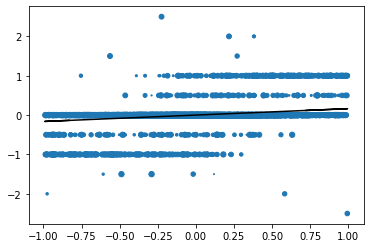

In [66]:
#Scatter PLot showing the positive relationship from threshold
from numpy.polynomial.polynomial import polyfit
rb2 = rb1.dropna()
y = rb2.DM  
x = rb2.OIR
b, m = polyfit(x, y, 1)
size = np.random.rand(41227)*30
plt.scatter(x,y, size)
plt.plot(x, b + m * x, '-', color = 'black')
plt.plot()

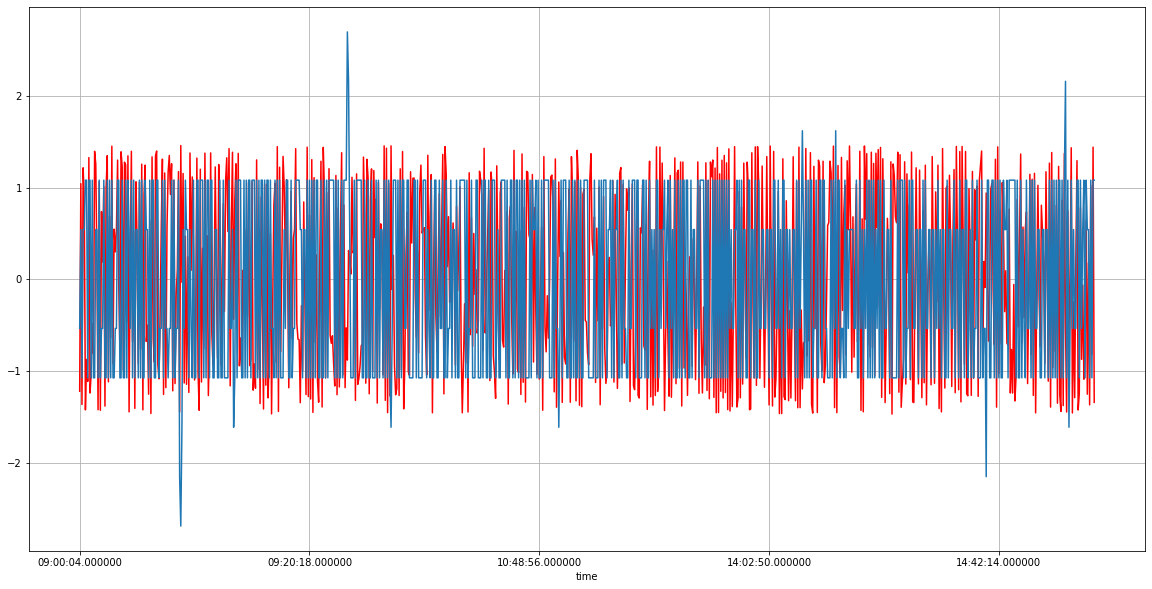

In [38]:
#Uniformization of values, such that it is easier to plot
#PLot of imbalance value vs midprice change
def uniformization(series):
    mean = np.mean(series)
    std = np.std(series)
    new_series = (series - mean)/std
    return new_series


#Plot of the 
uniformization(rb2['OIR'][:-1]).plot(color = 'r') #imbalance value
uniformization(rb2['DM'][1:]).plot(figsize=(20,10), grid=True)  #Mid price Change

[]

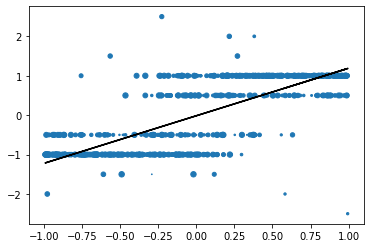

In [67]:
# Here is an example that we exclude zero midprice changes and see the scatter plot
rb2 = rb1.dropna()
rb2 = rb2[abs(rb2.DM) !=0]
y = rb2.DM  
x = rb2.OIR
b, m = polyfit(x, y, 1)
size = np.random.rand(41227)*30
plt.scatter(x,y, size)
plt.plot(x, b + m * x, '-', color = 'black')
plt.plot()